In [1]:
import jax 
jax.config.update("jax_enable_x64", True)
import cfp
import scanpy as sc
import anndata as ad
import numpy as np
import cfp.preprocessing as cfpp
import pandas as pd

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/optuna/study/_optimize.py:29: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [2]:
split = 6
model_name = "fanciful-leaf-465"

adata_train_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_train_{split}.h5ad"
adata_test_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_test_{split}.h5ad"
adata_ood_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_ood_{split}.h5ad"
adata_train = sc.read_h5ad(adata_train_path)
adata_test = sc.read_h5ad(adata_test_path)
adata_ood = sc.read_h5ad(adata_ood_path)
    



In [3]:
covariate_data_ood = adata_ood[~adata_ood.obs["condition"].str.contains("Vehicle")].obs.drop_duplicates(subset=["cell_line", "drug"])
covariate_data_test = adata_test[~adata_test.obs["condition"].str.contains("Vehicle")].obs.drop_duplicates(subset=["cell_line", "drug"])


In [6]:
covariate_data_ood["drug"]

index
A01_E09_RT_BC_108_Lig_BC_256-0-0    Quisinostat_(JNJ-26481585)_2HCl
A01_E09_RT_BC_116_Lig_BC_193-0-0         Alvespimycin_(17-DMAG)_HCl
A01_E09_RT_BC_129_Lig_BC_15-0-0                    Flavopiridol_HCl
A01_E09_RT_BC_136_Lig_BC_372-0-0                Belinostat_(PXD101)
A01_E09_RT_BC_136_Lig_BC_6-0-0                           Hesperadin
A01_E09_RT_BC_146_Lig_BC_333-0-0                Dacinostat_(LAQ824)
A01_E09_RT_BC_237_Lig_BC_319-0-0                            TAK-901
A01_E09_RT_BC_340_Lig_BC_218-0-0              Tanespimycin_(17-AAG)
A01_E09_RT_BC_381_Lig_BC_173-0-0               Givinostat_(ITF2357)
A01_E09_RT_BC_102_Lig_BC_110-1-0              Tanespimycin_(17-AAG)
A01_E09_RT_BC_11_Lig_BC_52-1-0                              TAK-901
A01_E09_RT_BC_123_Lig_BC_300-1-0                Belinostat_(PXD101)
A01_E09_RT_BC_125_Lig_BC_160-1-0         Alvespimycin_(17-DMAG)_HCl
A01_E09_RT_BC_129_Lig_BC_265-1-0                Dacinostat_(LAQ824)
A01_E09_RT_BC_133_Lig_BC_255-1-0          

In [7]:
covariate_data = covariate_data_ood[(covariate_data_ood["cell_line"]=="MCF7") & (covariate_data_ood["drug"]=="Dacinostat_(LAQ824)")]

In [8]:
covariate_data

cell_type  dose dose_character dose_pattern  \
index                                                                          
A01_E09_RT_BC_129_Lig_BC_265-1-0      MCF7  10.0             10            4   

                                 g1s_score g2m_score      pathway  \
index                                                               
A01_E09_RT_BC_129_Lig_BC_265-1-0   2.09247  0.884173  Epigenetics   

                                        pathway_level_1  \
index                                                     
A01_E09_RT_BC_129_Lig_BC_265-1-0  Epigenetic regulation   

                                        pathway_level_2  \
index                                                     
A01_E09_RT_BC_129_Lig_BC_265-1-0  Histone deacetylation   

                                            product_dose  ... pubchem_name  \
index                                                     ...                
A01_E09_RT_BC_129_Lig_BC_265-1-0  Dacinostat (LAQ824)_10  ...          NaN   

                                 pubchem_ID  \
index                                         
A01_E09_RT_BC_129_Lig_BC_265-1-0        NaN   

                                                                             smiles  \
index                                                                                 
A01_E09_RT_BC_129_Lig_BC_265-1-0  C1=CC=C2C(=C1)C(=CN2)CCN(CCO)CC3=CC=C(C=C3)/C=...   

                                 control    ood_1    ood_2  \
index                                                        
A01_E09_RT_BC_129_Lig_BC_265-1-0   False  not ood  not ood   

                                                          ood_3    ood_4  \
index                                                                      
A01_E09_RT_BC_129_Lig_BC_265-1-0  MCF7_Dacinostat_(LAQ824)_10.0  not ood   

                                                          ood_5 split  
index                                                                  
A01_E09_RT_BC_129_Lig_BC_265-1-0  MCF7_Dacinostat_(LAQ824)_10.0   ood  

[1 rows x 32 columns]

In [9]:
def duplicate_and_interpolate(df, column, start, end, steps):
    result = pd.DataFrame()
    
    for _, row in df.iterrows():
        new_rows = pd.DataFrame([row] * steps)  # Duplicate the row
        new_rows[column] = np.linspace(start, end, steps)  # Interpolate 'logdose'
        result = pd.concat([result, new_rows], ignore_index=True)
    
    return result

covariate_data_interpolated = duplicate_and_interpolate(covariate_data, 'logdose', 1.0, 4.0, 8)

In [10]:
adata_ood_ctrl = adata_ood[(adata_ood.obs["condition"].str.contains("Vehicle")) & (adata_ood.obs["cell_line"]=="MCF7")]
adata_ood_ctrl.obs["control"] = True

/tmp/ipykernel_2281459/493568434.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ood_ctrl.obs["control"] = True


In [11]:
adata_ood_ctrl.obs["condition"].value_counts()

condition
MCF7_Vehicle_0.0    500
Name: count, dtype: int64

In [12]:
cf = cfp.model.CellFlow.load(f"/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/out/{model_name}_CellFlow.pkl")



In [13]:
covariate_data_interpolated.loc[:, "condition"] = covariate_data_interpolated.apply(lambda x: "_".join([x.cell_type, x.drug, str(x.logdose)]), axis=1)

In [14]:
sc.pp.subsample(adata_ood_ctrl, fraction=0.2)

In [15]:
preds_ood = cf.predict(adata=adata_ood_ctrl, sample_rep="X_pca", condition_id_key="condition", covariate_data=covariate_data_interpolated)

/ictstr01/home/icb/dominik.klein/git_repos/cell_flow_perturbation/src/cfp/data/_datamanager.py:334: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _covariate_data["cell_index"] = _covariate_data.index
100%|██████████| 8/8 [00:00<00:00, 47.69it/s]


In [16]:
all_data = []
conditions = []

for condition, array in preds_ood.items():
    all_data.append(array)
    conditions.extend([condition] * array.shape[0])

# Stack all data vertically to create a single array
all_data_array = np.vstack(all_data)

# Create a DataFrame for the .obs attribute
obs_data = pd.DataFrame({
    'condition': conditions
})

# Create the Anndata object
adata_ood_result = ad.AnnData(X=np.empty((len(all_data_array),2001)), obs=obs_data)
adata_ood_result.obsm["X_pca_pred"] = all_data_array


/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [17]:
cfpp.reconstruct_pca(query_adata=adata_ood_result, use_rep="X_pca_pred", ref_adata=adata_train, layers_key_added="X_recon_pred")


In [18]:
adata_ood_result.X = adata_ood_result.layers["X_recon_pred"]

In [19]:
sc.pp.pca(adata_ood_result)
sc.pp.neighbors(adata_ood_result)
sc.tl.umap(adata_ood_result)

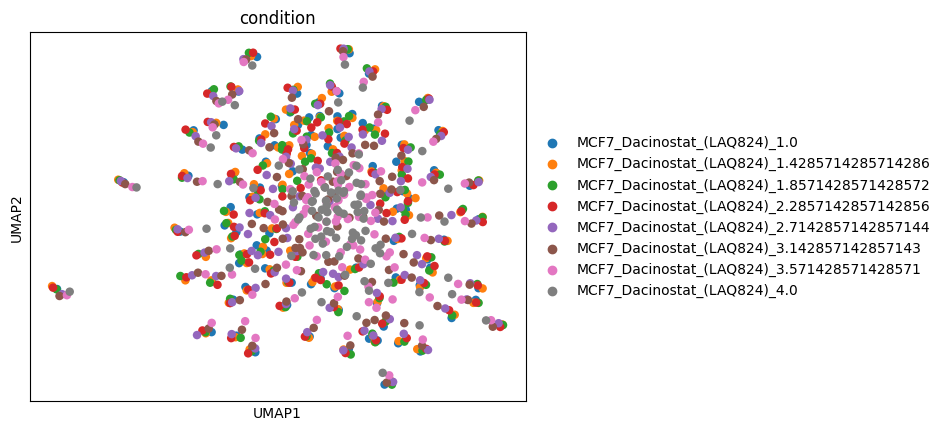

In [20]:
sc.pl.umap(adata_ood_result, color="condition")

In [21]:
adata_pred = adata_ood_result

In [92]:
adata_true2 = adata_ood[(adata_ood.obs["drug"]=="Dacinostat_(LAQ824)") & (adata_ood.obs["cell_type"]=="MCF7")]
adata_true = ad.concat((adata_ood_ctrl, adata_true2))

In [93]:
adata_pred.var_names = adata_true.var_names

In [94]:
adata_ood_result.obs["condition"].unique()

['MCF7_Dacinostat_(LAQ824)_1.0', 'MCF7_Dacinostat_(LAQ824)_1.4285714285714286', 'MCF7_Dacinostat_(LAQ824)_1.8571428571428572', 'MCF7_Dacinostat_(LAQ824)_2.2857142857142856', 'MCF7_Dacinostat_(LAQ824)_2.7142857142857144', 'MCF7_Dacinostat_(LAQ824)_3.142857142857143', 'MCF7_Dacinostat_(LAQ824)_3.571428571428571', 'MCF7_Dacinostat_(LAQ824)_4.0']
Categories (8, object): ['MCF7_Dacinostat_(LAQ824)_1.0', 'MCF7_Dacinostat_(LAQ824)_1.4285714285714286', 'MCF7_Dacinostat_(LAQ824)_1.8571428571428572', 'MCF7_Dacinostat_(LAQ824)_2.2857142857142856', 'MCF7_Dacinostat_(LAQ824)_2.7142857142857144', 'MCF7_Dacinostat_(LAQ824)_3.142857142857143', 'MCF7_Dacinostat_(LAQ824)_3.571428571428571', 'MCF7_Dacinostat_(LAQ824)_4.0']

In [101]:
genes = adata_true.var_names

control = adata_ood_ctrl[adata_ood_ctrl.obs['condition'] == 'MCF7_Vehicle_0.0']
mean_control = np.mean(np.asarray(control.X.toarray()), axis=0)  

all_dfs = []

for cond in adata_true2.obs["condition"].unique():
    if cond=="control" or "10000.0" not in cond:
        continue
    treated = adata_true2[adata_true2.obs['condition'] == cond]
    mean_treated = np.mean(np.asarray(treated.X.toarray()), axis=0)  
    log_fold_change = np.log2(mean_treated + 1) - np.log2(mean_control + 1)
    logfc_df = pd.DataFrame({
        'gene': genes,
        'log_fold_change': log_fold_change,
    })
    all_dfs.append(logfc_df)

df_logfoldchanges = pd.concat(all_dfs)

In [102]:
adata_true2.obs["condition"].unique()


['MCF7_Dacinostat_(LAQ824)_10.0', 'MCF7_Dacinostat_(LAQ824)_10000.0', 'MCF7_Dacinostat_(LAQ824)_100.0', 'MCF7_Dacinostat_(LAQ824)_1000.0']
Categories (4, object): ['MCF7_Dacinostat_(LAQ824)_10.0', 'MCF7_Dacinostat_(LAQ824)_100.0', 'MCF7_Dacinostat_(LAQ824)_1000.0', 'MCF7_Dacinostat_(LAQ824)_10000.0']

In [103]:
df_logfoldchanges.sort_values("log_fold_change")

gene  log_fold_change
379        GFRA1        -0.918343
768       MALRD1        -0.688143
627      SLC24A3        -0.665393
519        DSCAM        -0.655235
202       PLXDC2        -0.640902
...          ...              ...
321        RPL3L         1.248597
1067   CEACAM22P         1.334465
207        TEX14         1.347938
1613  AC008050.1         1.355320
421      COL26A1         1.799786

[2001 rows x 2 columns]

In [86]:
adata_true.obs["condition"]

index
B04_E09_RT_BC_198_Lig_BC_114-1-0                   MCF7_Vehicle_0.0
E02_E09_RT_BC_222_Lig_BC_236-1-0                   MCF7_Vehicle_0.0
E07_F10_RT_BC_32_Lig_BC_15-1-0                     MCF7_Vehicle_0.0
H02_F10_RT_BC_359_Lig_BC_71-1-0                    MCF7_Vehicle_0.0
H05_F10_RT_BC_160_Lig_BC_1-1-0                     MCF7_Vehicle_0.0
                                                 ...               
H12_F10_RT_BC_335_Lig_BC_232-1-0    MCF7_Dacinostat_(LAQ824)_1000.0
H12_F10_RT_BC_338_Lig_BC_226-1-0      MCF7_Dacinostat_(LAQ824)_10.0
H12_F10_RT_BC_36_Lig_BC_225-1-0     MCF7_Dacinostat_(LAQ824)_1000.0
H12_F10_RT_BC_69_Lig_BC_132-1-0       MCF7_Dacinostat_(LAQ824)_10.0
H12_F10_RT_BC_99_Lig_BC_191-1-0     MCF7_Dacinostat_(LAQ824)_1000.0
Name: condition, Length: 1667, dtype: category
Categories (5, object): ['MCF7_Dacinostat_(LAQ824)_10.0', 'MCF7_Dacinostat_(LAQ824)_100.0', 'MCF7_Dacinostat_(LAQ824)_1000.0', 'MCF7_Dacinostat_(LAQ824)_10000.0', 'MCF7_Vehicle_0.0']

In [85]:
adata_ood_result.obs["condition"]

0      MCF7_Dacinostat_(LAQ824)_1.0
1      MCF7_Dacinostat_(LAQ824)_1.0
2      MCF7_Dacinostat_(LAQ824)_1.0
3      MCF7_Dacinostat_(LAQ824)_1.0
4      MCF7_Dacinostat_(LAQ824)_1.0
                   ...             
795    MCF7_Dacinostat_(LAQ824)_4.0
796    MCF7_Dacinostat_(LAQ824)_4.0
797    MCF7_Dacinostat_(LAQ824)_4.0
798    MCF7_Dacinostat_(LAQ824)_4.0
799    MCF7_Dacinostat_(LAQ824)_4.0
Name: condition, Length: 800, dtype: category
Categories (8, object): ['MCF7_Dacinostat_(LAQ824)_1.0', 'MCF7_Dacinostat_(LAQ824)_1.4285714285714286', 'MCF7_Dacinostat_(LAQ824)_1.8571428571428572', 'MCF7_Dacinostat_(LAQ824)_2.2857142857142856', 'MCF7_Dacinostat_(LAQ824)_2.7142857142857144', 'MCF7_Dacinostat_(LAQ824)_3.142857142857143', 'MCF7_Dacinostat_(LAQ824)_3.571428571428571', 'MCF7_Dacinostat_(LAQ824)_4.0']

In [80]:
df_logfoldchanges

gene  log_fold_change
0             CFH              NaN
1            GCLC              NaN
2          SLC4A1              NaN
3           CALCR              NaN
4          THSD7A              NaN
...           ...              ...
1996        OR8B3              NaN
1997   AL354702.2              NaN
1998  AC073869.10              NaN
1999   AP001153.1              NaN
2000     PDE11A-1              NaN

[2001 rows x 2 columns]

In [35]:
adata_true.obs["mode"] = "True"
adata_pred.obs["mode"] = "pred"

/tmp/ipykernel_2281459/4144871509.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_true.obs["mode"] = "True"


In [36]:
adata_joint = ad.concat((adata_true, adata_pred))

In [37]:
sc.pp.pca(adata_joint, n_comps=5)
sc.pp.neighbors(adata_joint)
sc.tl.umap(adata_joint)

In [38]:
adata_joint.obs["dose"] = adata_joint.obs.apply(lambda x: x["condition"].split("_")[-1], axis=1)

In [39]:
adata_joint.obs["dose"] =adata_joint.obs["dose"].astype("float") 

In [40]:
adata_joint.obs["logdose"] = adata_joint.obs.apply(lambda x: np.log10(x["dose"]) if (x["dose"] in [10, 100, 1000, 10000]) else x["dose"], axis=1)

In [41]:
adata_joint.obs["logdose"].value_counts()

logdose
1.000000    554
4.000000    535
3.000000    358
2.000000    320
1.428571    100
1.857143    100
2.285714    100
2.714286    100
3.142857    100
3.571429    100
Name: count, dtype: int64

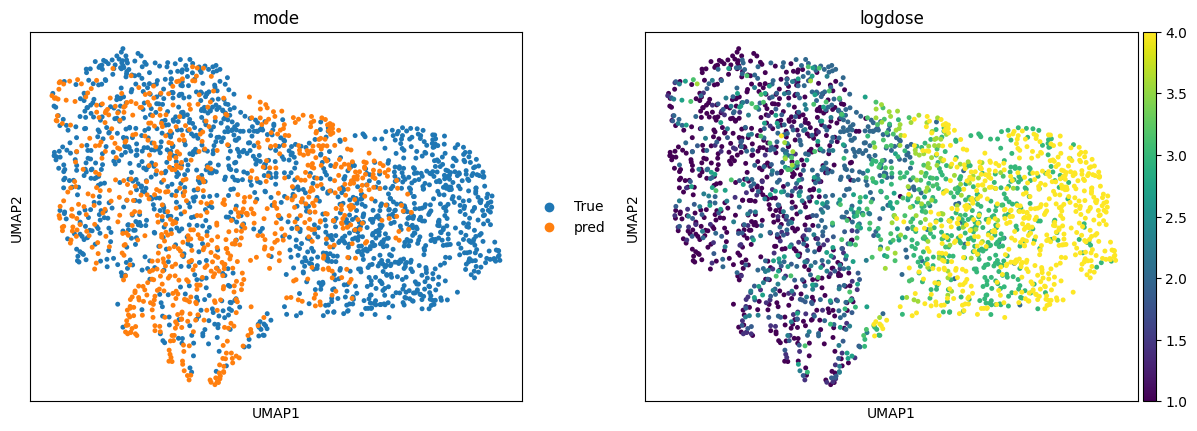

In [42]:
sc.pl.umap(adata_joint, color=["mode", "logdose"])

In [69]:
genes = adata_true.var_names

control = adata_ood_ctrl[adata_ood_ctrl.obs['condition'] == 'MCF7_Vehicle_0.0']
mean_control = np.mean(np.asarray(control.X.toarray()), axis=0)  

all_dfs = []

for cond in adata_ood_result.obs["condition"].unique():
    if cond=="control" or "10000.0" not in cond:
        continue
    treated = adata_ood_result[adata_ood_result.obs['condition'] == cond]
    mean_treated = np.mean(np.asarray(treated.X.toarray()), axis=0)  
    log_fold_change = np.log2(mean_treated + 1) - np.log2(mean_control + 1)
    logfc_df = pd.DataFrame({
        'gene': genes,
        'log_fold_change': log_fold_change,
    })
    all_dfs.append(logfc_df)

df_logfoldchanges = pd.concat(all_dfs)

NameError: name 'adata_ood_true' is not defined

In [104]:
upregulated_genes = list(df_logfoldchanges.sort_values("log_fold_change")[-10:].gene.values)
downregulated_genes = list(df_logfoldchanges.sort_values("log_fold_change")[:10].gene.values)
df_upregulation = sc.get.obs_df(adata_joint, keys=upregulated_genes+['logdose'])
df_upregulation["mode"] =adata_joint.obs["mode"]
df_downregulation = sc.get.obs_df(adata_joint, keys=downregulated_genes+['logdose'])
df_downregulation["mode"] =adata_joint.obs["mode"]

In [128]:
df_upregulation.iloc[df_upregulation["mode"].values=="True",:].groupby("logdose").count()

DHRS2  PPM1E  ACSBG1  LINC00624  AC092957.1  RPL3L  CEACAM22P  TEX14  \
logdose                                                                         
1.0        454    454     454        454         454    454        454    454   
2.0        320    320     320        320         320    320        320    320   
3.0        358    358     358        358         358    358        358    358   
4.0        435    435     435        435         435    435        435    435   

         AC008050.1  COL26A1  mode  
logdose                             
1.0             454      454   454  
2.0             320      320   320  
3.0             358      358   358  
4.0             435      435   435

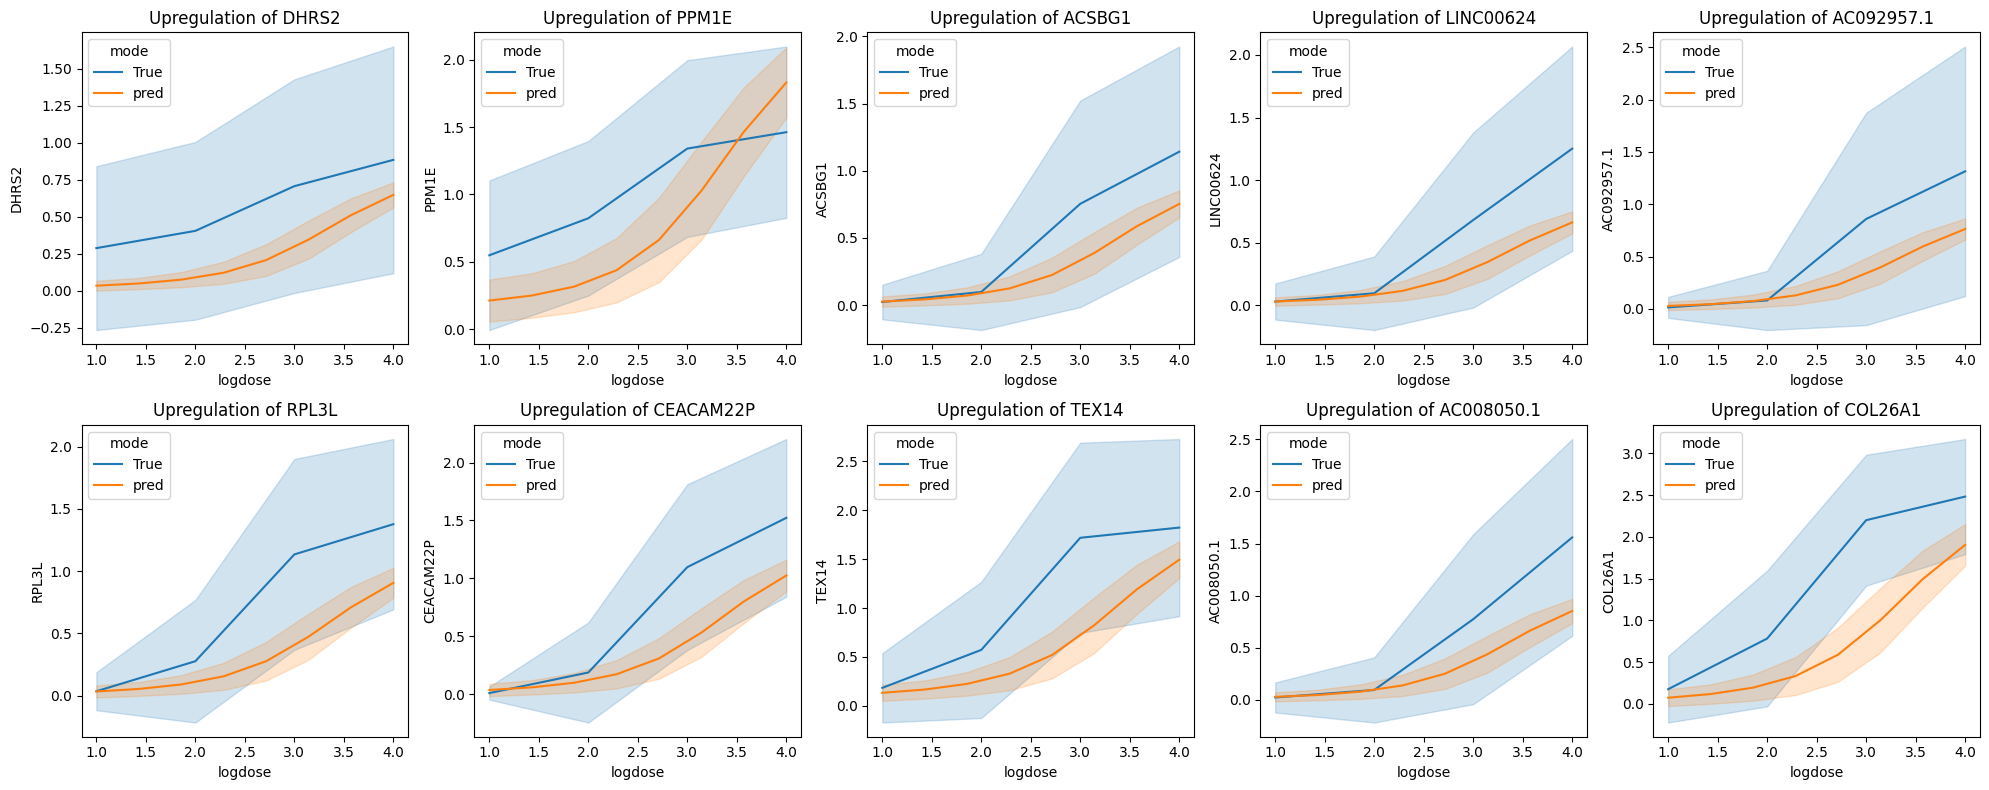

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Define number of rows and columns for 5 plots per row
num_genes = len(upregulated_genes)
cols = 5
rows = math.ceil(num_genes / cols)  # Calculate required number of rows

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))

# Flatten axes array in case it's a multi-dimensional array
axes = axes.flatten()

# Create a lineplot for each gene
for i, gene in enumerate(upregulated_genes):
    sns.lineplot(data=df_upregulation, x='logdose', y=gene, errorbar='sd', hue="mode", ax=axes[i])
    axes[i].set_title(f'Upregulation of {gene}')

# Remove any unused subplots if the number of genes isn't a multiple of 5
for i in range(num_genes, rows * cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


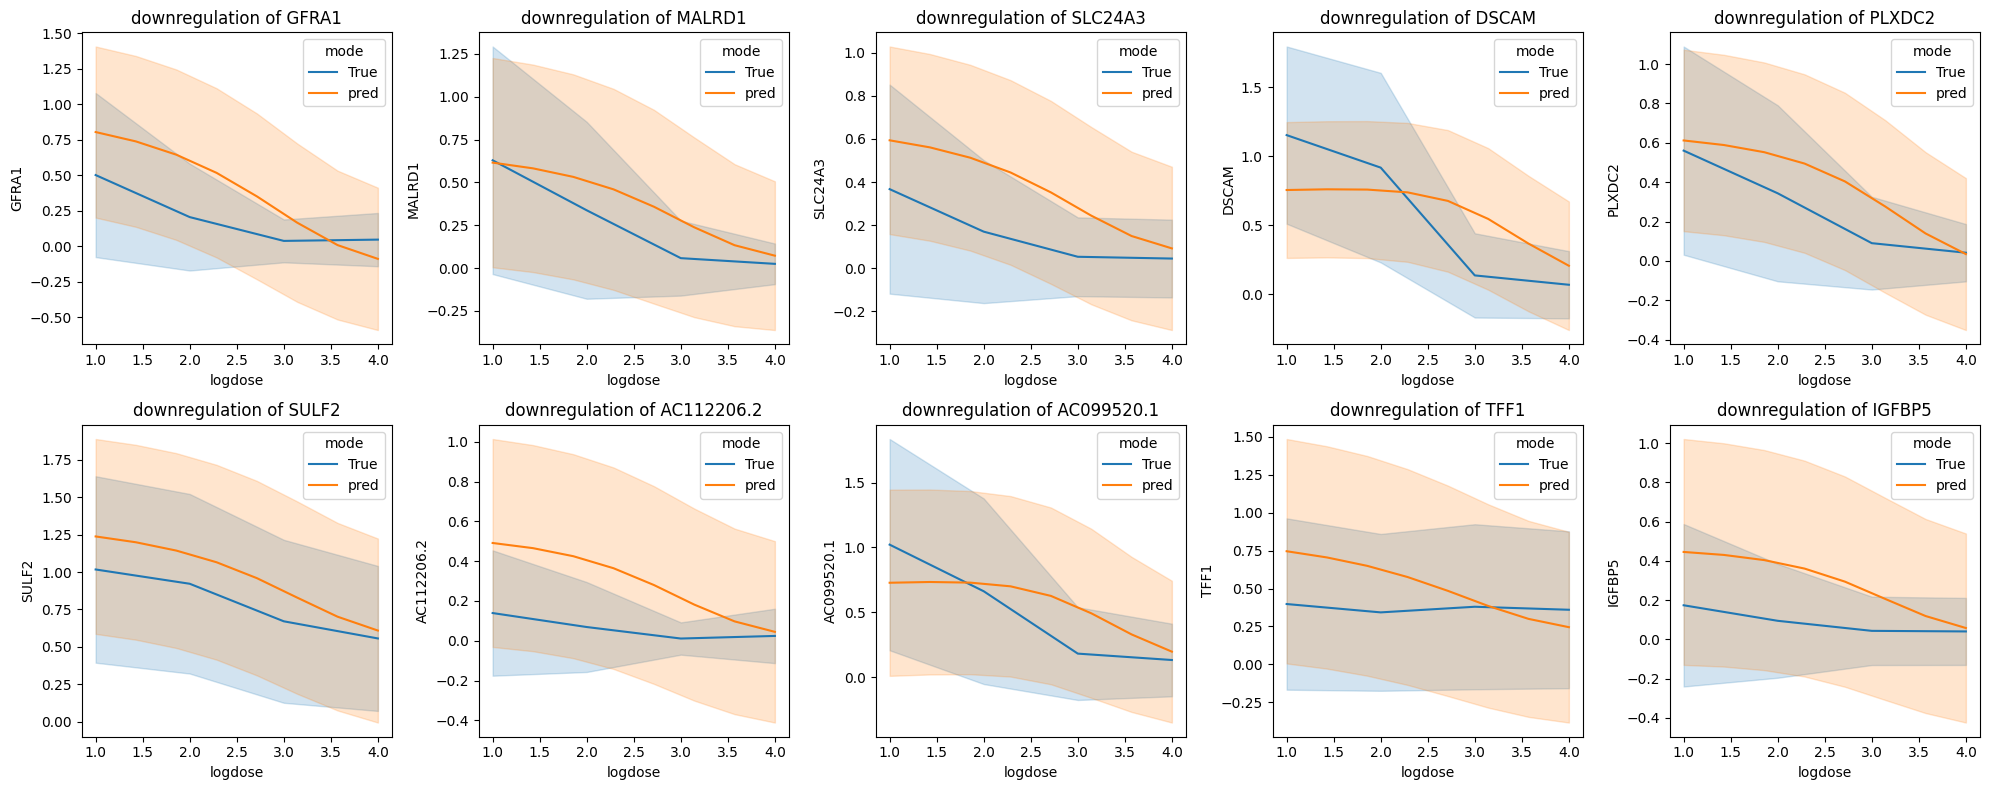

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Define number of rows and columns for 5 plots per row
num_genes = len(downregulated_genes)
cols = 5
rows = math.ceil(num_genes / cols)  # Calculate required number of rows

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))

# Flatten axes array in case it's a multi-dimensional array
axes = axes.flatten()

# Create a lineplot for each gene
for i, gene in enumerate(downregulated_genes):
    sns.lineplot(data=df_downregulation, x='logdose', y=gene, errorbar='sd', hue="mode", ax=axes[i])
    axes[i].set_title(f'downregulation of {gene}')

# Remove any unused subplots if the number of genes isn't a multiple of 5
for i in range(num_genes, rows * cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


/tmp/ipykernel_2281459/1317999174.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pred_data = df_downregulation[df_downregulation['mode'] == 'pred'].groupby('logdose').apply(lambda x: x.sample(4, random_state=42)).reset_index(drop=True)
/tmp/ipykernel_2281459/1317999174.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  non_pred_data = df_downregulation[df_downregulation['mode'] != 'pred'].groupby('l

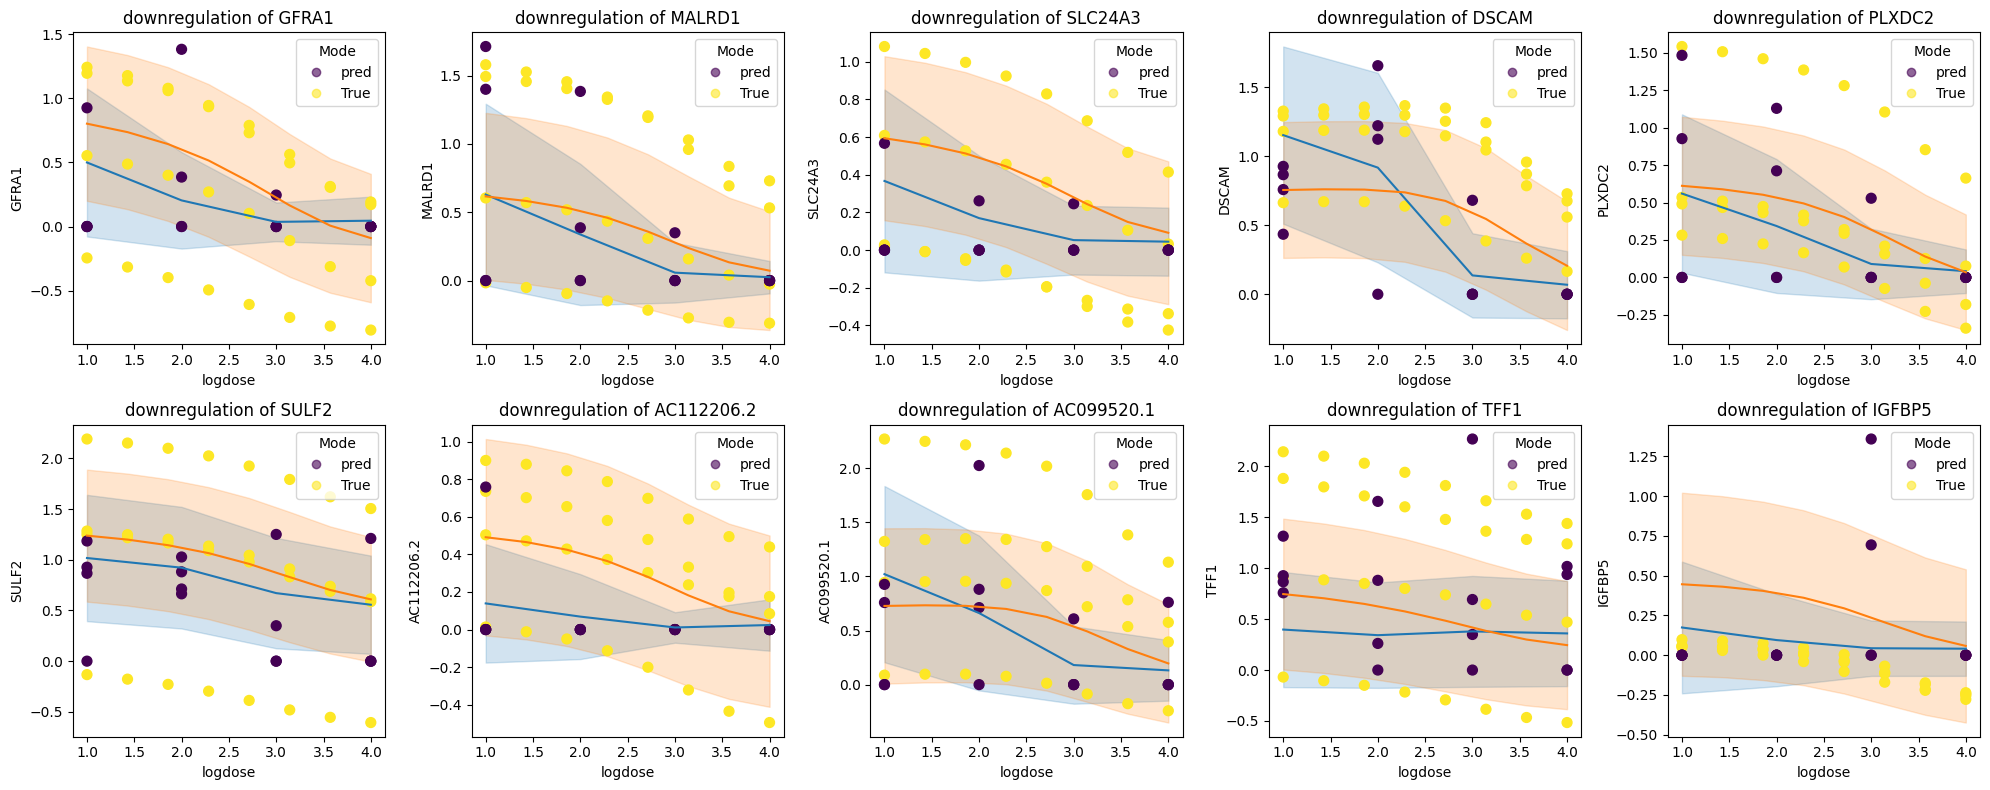

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Define number of rows and columns for 5 plots per row
num_genes = len(downregulated_genes)
cols = 5
rows = math.ceil(num_genes / cols)  # Calculate required number of rows

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))

# Flatten axes array in case it's a multi-dimensional array
axes = axes.flatten()

# Create a lineplot for each gene
for i, gene in enumerate(downregulated_genes):
    # Create line plot
    sns.lineplot(data=df_downregulation, x='logdose', y=gene, errorbar='sd', hue="mode", ax=axes[i])

    # Filter and select exactly 4 data points per logdose for "pred"
    pred_data = df_downregulation[df_downregulation['mode'] == 'pred'].groupby('logdose').apply(lambda x: x.sample(4, random_state=42)).reset_index(drop=True)

    # Select up to 4 data points for other modes, if available
    non_pred_data = df_downregulation[df_downregulation['mode'] != 'pred'].groupby('logdose').apply(lambda x: x.sample(4, random_state=42)).reset_index(drop=True)

    # Combine both selections
    selected_data = pd.concat([pred_data, non_pred_data])

    # Scatter plot to add specific points and color them by 'mode'
    scatter = axes[i].scatter(selected_data['logdose'], selected_data[gene], c=selected_data['mode'].astype('category').cat.codes, cmap='viridis', s=50, label='4 Data Points per logdose')

    # Create colorbar for 'mode'
    handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
    legend_labels = selected_data['mode'].unique()
    axes[i].legend(handles, legend_labels, title="Mode")

    axes[i].set_title(f'downregulation of {gene}')

# Remove any unused subplots if the number of genes isn't a multiple of 5
for i in range(num_genes, rows * cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [43]:
adata_joint

AnnData object with n_obs × n_vars = 2367 × 2001
    obs: 'condition', 'mode', 'dose', 'logdose'
    uns: 'pca', 'neighbors', 'umap', 'mode_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [44]:
adata_joint.var_names

Index(['CFH', 'GCLC', 'SLC4A1', 'CALCR', 'THSD7A', 'ACSM3', 'PRKAR2B', 'TAC1',
       'ETV1', 'TBXA2R',
       ...
       'AL590132.1', 'MIR7114', 'MIR19B1', 'MIR2110', 'MIR1304', 'OR8B3',
       'AL354702.2', 'AC073869.10', 'AP001153.1', 'PDE11A-1'],
      dtype='object', name='index', length=2001)

In [45]:
df = sc.get.obs_df(adata_joint, keys=["ACSS2",'GCLC', 'logdose'])
df["mode"] =adata_joint.obs["mode"]

In [46]:
df["mode"] =adata_joint.obs["mode"]

In [47]:
df

ACSS2      GCLC  logdose  mode
A01_E09_RT_BC_129_Lig_BC_265-1-0  0.000000  0.000000      1.0  True
A01_E09_RT_BC_152_Lig_BC_328-1-0  0.000000  0.000000      4.0  True
A01_E09_RT_BC_202_Lig_BC_303-1-0  0.000000  0.724165      2.0  True
A01_E09_RT_BC_219_Lig_BC_335-1-0  0.000000  0.000000      3.0  True
A01_E09_RT_BC_274_Lig_BC_119-1-0  0.000000  0.000000      1.0  True
...                                    ...       ...      ...   ...
795                               0.165818  0.322338      4.0  pred
796                               0.171974  0.419060      4.0  pred
797                               0.130704  0.251646      4.0  pred
798                               0.107935  0.355798      4.0  pred
799                               0.207805  0.264820      4.0  pred

[2367 rows x 4 columns]

In [48]:
df = plot_

NameError: name 'plot_' is not defined

In [49]:
import matplotlib.colors as mcolors

colors = [
    "#ffcccc",
    "#ff9999",
    "#ff6666",
    "#ff3333",
    "#ff0000",
    "#cc0000",
    "#990000",
]
red_cmap = mcolors.LinearSegmentedColormap.from_list("light_to_dark_red", colors)

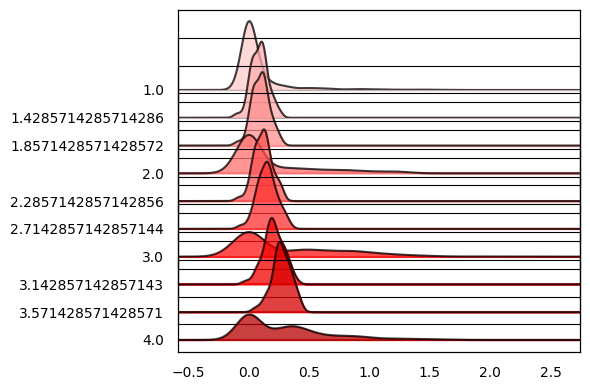

In [53]:
_ = plot_densities(df, feature=['GCLC'], group_by="logdose",alpha=0.75,
    figsize=(6, 4),
    grid='both',
    colormap= red_cmap)

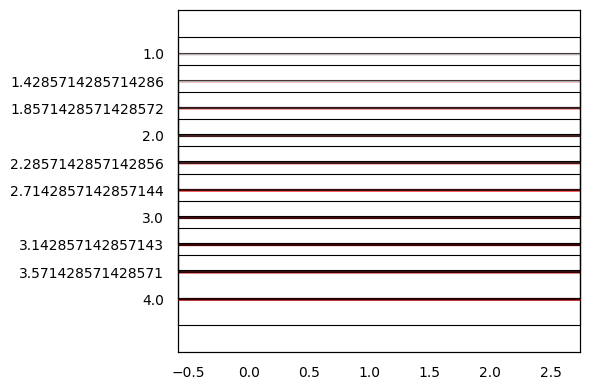

In [68]:
_ = plot_densities(df, feature=['GCLC'], group_by="logdose",alpha=0.75,
    figsize=(6, 4),
    grid='both',
    density_fit='log1',
    colormap= red_cmap)

/tmp/ipykernel_2281459/563704830.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pred_data = df_downregulation[df_downregulation['mode'] == 'pred'].groupby('logdose').apply(lambda x: x.sample(min(4, len(x)), random_state=42)).reset_index(drop=True)
/tmp/ipykernel_2281459/563704830.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  non_pred_data = df_downregulation[df_downregulation['mode'] != 'pred']

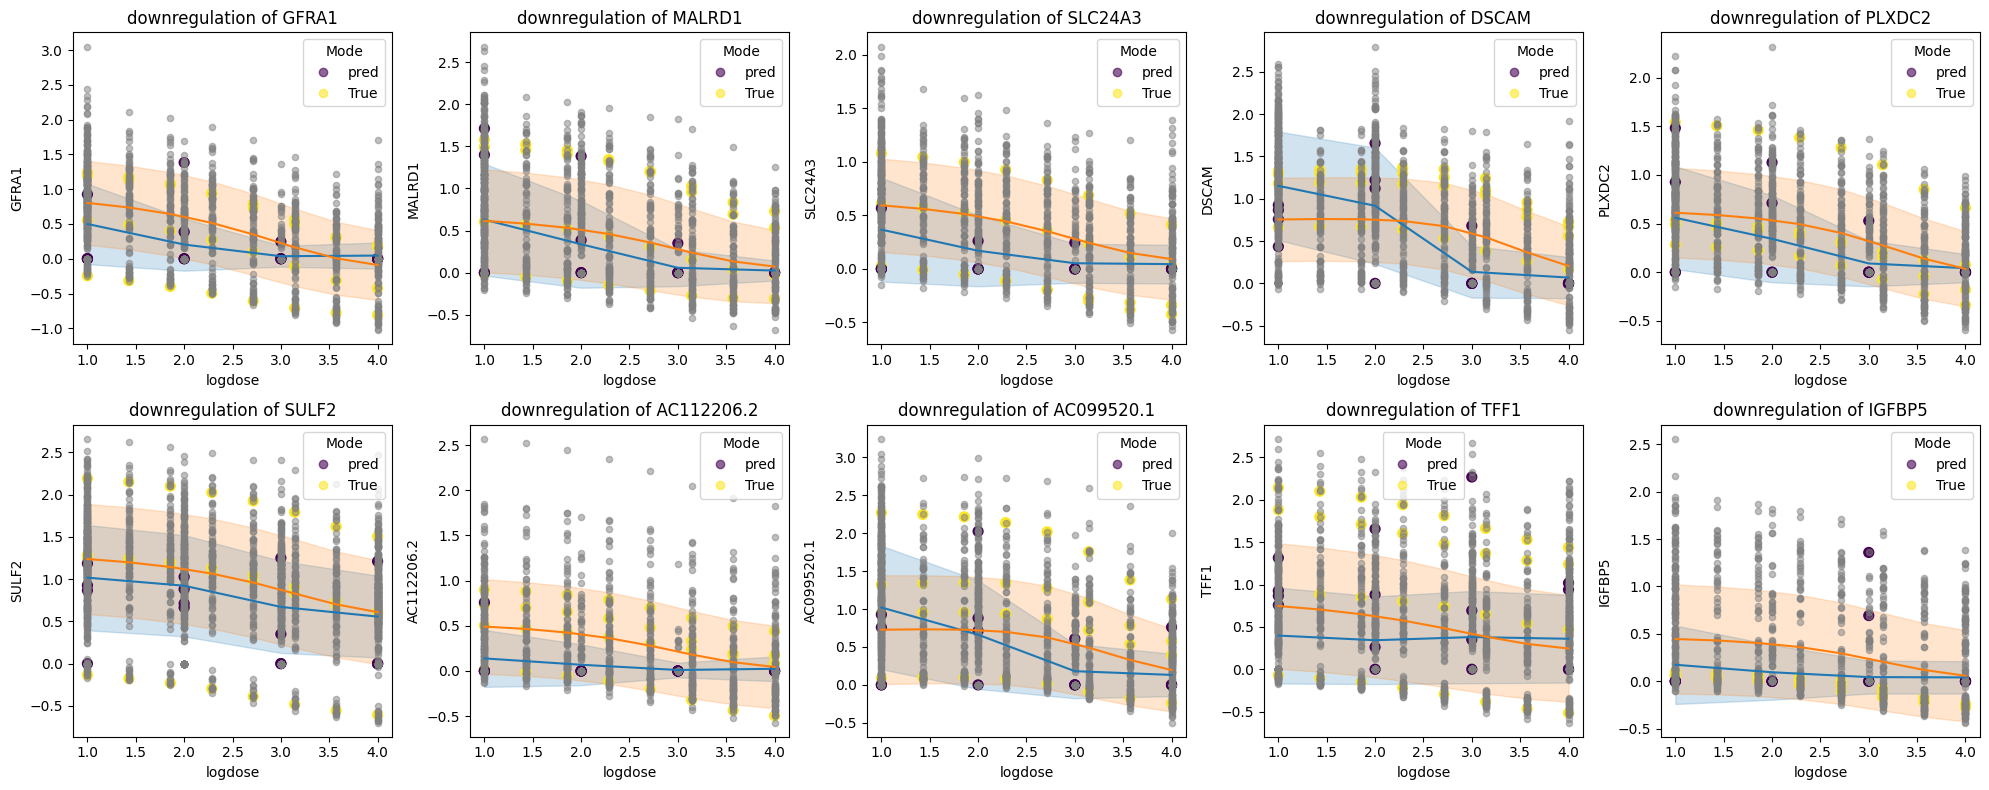

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd

# Define number of rows and columns for 5 plots per row
num_genes = len(downregulated_genes)
cols = 5
rows = math.ceil(num_genes / cols)  # Calculate required number of rows

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))

# Flatten axes array in case it's a multi-dimensional array
axes = axes.flatten()

# Create a lineplot for each gene
for i, gene in enumerate(downregulated_genes):
    # Create line plot
    sns.lineplot(data=df_downregulation, x='logdose', y=gene, errorbar='sd', hue="mode", ax=axes[i])

    # Filter and select exactly 4 data points per logdose for "pred"
    pred_data = df_downregulation[df_downregulation['mode'] == 'pred'].groupby('logdose').apply(lambda x: x.sample(min(4, len(x)), random_state=42)).reset_index(drop=True)

    # Select up to 4 data points for other modes, if available
    non_pred_data = df_downregulation[df_downregulation['mode'] != 'pred'].groupby('logdose').apply(lambda x: x.sample(min(4, len(x)), random_state=42)).reset_index(drop=True)

    # Combine both selections
    selected_data = pd.concat([pred_data, non_pred_data])

    # Scatter plot to add specific points (highlighted selection)
    scatter = axes[i].scatter(selected_data['logdose'], selected_data[gene], c=selected_data['mode'].astype('category').cat.codes, cmap='viridis', s=50, label='4 Data Points per logdose')

    # Plot all data points on top
    axes[i].scatter(df_downregulation['logdose'], df_downregulation[gene], color='gray', s=20, alpha=0.5, label='All Data Points')

    # Create legend for the modes (highlighted data points)
    handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
    legend_labels = selected_data['mode'].unique()
    axes[i].legend(handles, legend_labels, title="Mode")

    axes[i].set_title(f'downregulation of {gene}')

# Remove any unused subplots if the number of genes isn't a multiple of 5
for i in range(num_genes, rows * cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [51]:
import types
from collections.abc import Sequence
from typing import Any, Literal

import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from adjustText import adjust_text

from cfp import _constants
from cfp import _constants, _logging


def plot_densities(
    data: pd.DataFrame,
    feature: str,
    group_by: str | None = None,
    density_fit: Literal["log1p", "raw"] = "raw",
    ax: mpl.axes.Axes | None = None,
    figsize: tuple[float, float] | None = None,
    dpi: int | None = None,
    xlabels: bool = False,
    ylabels: bool = True,
    xlabelsize: float | None = None,
    xrot: float | None = None,
    labels: Sequence[Any] = None,
    ylabelsize: float | None = None,
    yrot: float | None = None,
    hist: bool = False,
    bins: int = 10,
    fade: bool = False,
    ylim: Literal["max"] | tuple[float, float] | None = "max",
    fill: bool = True,
    linecolor: Any = None,
    overlap: float = 1.0,
    background: Any = None,
    range_style: Literal["all", "individual", "group"] | list[float] = "all",
    x_range: tuple[float, float] = None,
    title: str | None = None,
    colormap: str | mpl.colors.Colormap | None = None,
    color: Any = None,
    grid: bool = False,
    return_fig: bool = True,
    **kwargs,
):
    """Plot kernel density estimations of expressions.
    This function is adapted from https://github.com/leotac/joypy/blob/master/joypy/joyplot.py
    Parameters
    ----------
    data
        :class:`pandas.DataFrame` object containing (predicted) expression values.
    feature
        Column in ``'data'`` to plot.
    group_by
        Column in ``'data'`` to group by.
    density_fit
        Type of density fit to use. If "raw", the kernel density estimation is plotted. If "log1p", the log1p
        transformed values of the densities are plotted.
    ax
        :class:`matplotlib.axes.Axes` used for plotting. If :obj:`None`, create a new one.
    figsize
        Size of the figure.
    dpi
        Dots per inch.
    xlabels
        Whether to show x-axis labels.
    ylabels
        Whether to show y-axis labels.
    xlabelsize
        Size of the x-axis labels.
    xrot
        Rotation (in degrees) of the x-axis labels.
    labels
        Sequence of labels for each density plot.
    ylabelsize
        Size of the y-axis labels.
    yrot
        Rotation (in degrees) of the y-axis labels.
    hist
        If :obj:`True`, plot a histogram, otherwise a density plot.
    bins
        Number of bins to use, only applicable if ``hist`` is :obj:`True`.
    fade
        If :obj:`True`, automatically sets different values of transparency of the density plots.
    ylim
        Limits of the y-axis.
    fill
        Whether to fill the density plots. If :obj:`False`, only the lines are plotted.
    linecolor: :mpltype:`color`
        Color of the contour lines.
    overlap
        Overlap between the density plots. The higher the value, the more overlap between densities.
    background: :mpltype:`color`
        Background color of the plot.
    range_style
        Style of the range. Options are
        - "all" - all density plots have the same range, autmoatically determined.
        - "individual" - every density plot has its own range, automatically determined.
        - "group" - each plot has a range that covers the whole group
        - type :obj:`list` - custom ranges for each density plot.
    x_range
        Custom range for the x-axis, shared across all density plots. If :obj:`None`, set via ``'range_style'``.
    title
        Title of the plot.
    colormap
        Colormap to use.
    color: :mpltype:`color`
        Color of the density plots.
    grid
        Whether to show the grid.
    return_fig
        Whether to return the figure.
    kwargs
        Additional keyword arguments for the plot.
    Returns
    -------
    :class:`matplotlib.figure.Figure` if ``'return_fig'`` is :obj:`True`, else :obj:`None`.
    """
    if group_by is not None and isinstance(data, pd.DataFrame):
        grouped = data.groupby(group_by)
        if feature is None:
            feature = list(data.columns)
            feature.remove(group_by)
        converted, _labels, sublabels = _grouped_df_to_standard(grouped, feature)  # type: ignore[arg-type]
        if labels is None:
            labels = _labels
    elif isinstance(data, pd.DataFrame):
        if feature is not None:
            data = data[feature]
        converted = [
            [_remove_na(data[col])] for col in data.columns if _is_numeric(data[col])
        ]
        labels = [col for col in data.columns if _is_numeric(data[col])]
        sublabels = None
    else:
        raise TypeError(f"Unknown type for 'data': {type(data)!r}")

    if ylabels is False:
        labels = None

    if all(len(subg) == 0 for g in converted for subg in g):
        raise ValueError(
            "No numeric values found. Joyplot requires at least a numeric column/group."
        )

    if any(len(subg) == 0 for g in converted for subg in g):
        _logging.logger.warning("At least a column/group has no numeric values.")

    fig, axes = _joyplot(
        converted,
        labels=labels,
        sublabels=sublabels,
        grid=grid,
        xlabelsize=xlabelsize,
        xrot=xrot,
        ylabelsize=ylabelsize,
        yrot=yrot,
        ax=ax,
        dpi=dpi,
        figsize=figsize,
        hist=hist,
        bins=bins,
        fade=fade,
        ylim=ylim,
        fill=fill,
        linecolor=linecolor,
        overlap=overlap,
        background=background,
        xlabels=xlabels,
        range_style=range_style,
        x_range=x_range,
        title=title,
        colormap=colormap,
        color=color,
        density_fit=density_fit,
        **kwargs,
    )
    return fig if return_fig else None

In [52]:
from typing import Any, Literal

import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from pandas.core.dtypes.common import is_number
from pandas.plotting._matplotlib.tools import create_subplots as _subplots
from pandas.plotting._matplotlib.tools import flatten_axes as _flatten
from scipy.stats import gaussian_kde
from sklearn.decomposition import KernelPCA
from sklearn.metrics.pairwise import cosine_similarity

from cfp import _constants, _logging
from cfp._types import ArrayLike

def _x_range(data: ArrayLike | list[float], extra: float = 0.2) -> ArrayLike:
    """Compute the x_range for density estimation."""
    try:
        sample_range = np.nanmax(data) - np.nanmin(data)
    except ValueError:
        return np.array([])
    if sample_range < 1e-6:
        return np.array([np.nanmin(data), np.nanmax(data)])
    return np.linspace(
        np.nanmin(data) - extra * sample_range,
        np.nanmax(data) + extra * sample_range,
        1000,
    )


def _setup_axis(
    ax: plt.Axes,
    x_range: ArrayLike,
    col_name: str | None = None,
    grid: bool = False,
    ylabelsize: int | None = None,
    yrot: int | None = None,
) -> None:
    """Setup the axis for the joyplot."""
    if col_name is not None:
        ax.set_yticks([0])
        ax.set_yticklabels([col_name], fontsize=ylabelsize, rotation=yrot)
        ax.yaxis.grid(grid)
    else:
        ax.yaxis.set_visible(False)
    ax.patch.set_alpha(0)
    ax.set_xlim([x_range.min(), x_range.max()])
    ax.tick_params(axis="both", which="both", length=0, pad=10)


def _get_alpha(i: int, n: int, start: float = 0.4, end: float = 1.0) -> float:
    """Compute alpha value for plotting."""
    return start + (1 + i) * (end - start) / n


def _is_numeric(x: ArrayLike) -> bool:
    """Whether the array x is numeric."""
    return all(is_number(i) for i in x)


def _remove_na(data: list[Any] | ArrayLike | pd.Series) -> ArrayLike:
    """Remove NA values from the data."""
    return pd.Series(data).dropna().values


def _moving_average(a: ArrayLike, n: int = 3, zero_padded: bool = False) -> ArrayLike:
    """Calculate the moving average of order n."""
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    if zero_padded:
        return ret / n
    else:
        return ret[n - 1 :] / n


def _grouped_df_to_standard(
    grouped: pd.api.typing.DataFrameGroupBy, column: str | None
) -> tuple[pd.DataFrame, list[str], list[str]]:
    converted = []
    labels = []
    for i, (key, group) in enumerate(grouped):
        if column is not None:
            group = group[column]
        labels.append(key)
        converted.append(
            [_remove_na(group[c]) for c in group.columns if _is_numeric(group[c])]
        )
        if i == 0:
            sublabels = [col for col in group.columns if _is_numeric(group[col])]
    return converted, labels, sublabels


def _joyplot(
    data: pd.DataFrame,
    grid: bool = False,
    density_fit: Literal["log1p", "raw"] = "raw",
    labels=None,
    sublabels=None,
    xlabels=True,
    xlabelsize=None,
    xrot=None,
    ylabelsize=None,
    yrot=None,
    ax: mpl.axes.Axes | None = None,
    dpi: int | None = None,
    figsize: tuple[float, float] | None = None,
    hist: bool = False,
    bins=10,
    fade: bool = False,
    ylim="max",
    fill=True,
    linecolor=None,
    overlap: float = 1.0,
    background: Any = None,
    range_style: Literal["all", "individual", "group"] | list[float] = "all",
    x_range: tuple[float, float] = None,
    tails: float = 0.2,
    title: str | None = None,
    legend=False,
    loc="upper right",
    colormap: str | mpl.colors.Colormap | None = None,
    color=None,
    **kwargs,
) -> tuple[plt.Figure, list[plt.Axes]]:
    if fill is True and linecolor is None:
        linecolor = "k"

    if sublabels is None:
        legend = False

    def _get_color(i, num_axes, j, num_subgroups):
        if isinstance(color, list):
            return color[j] if num_subgroups > 1 else color[i]
        elif color is not None:
            return color
        elif isinstance(colormap, list):
            return colormap[j](i / num_axes)
        elif color is None and colormap is None:
            num_cycle_colors = len(plt.rcParams["axes.prop_cycle"].by_key()["color"])
            return plt.rcParams["axes.prop_cycle"].by_key()["color"][
                j % num_cycle_colors
            ]
        else:
            return colormap(i / num_axes)  # type: ignore[operator]

    ygrid = grid is True or grid == "y" or grid == "both"
    xgrid = grid is True or grid == "x" or grid == "both"

    num_axes = len(data)

    if x_range is None:
        global_x_range = _x_range([v for g in data for sg in g for v in sg])
    else:
        global_x_range = _x_range(x_range, 0.0)  # type: ignore[arg-type]

    # Each plot will have its own axis
    fig, axes = _subplots(
        naxes=num_axes,
        dpi=dpi,
        ax=ax,
        squeeze=False,
        sharex=True,
        sharey=False,
        figsize=figsize,
        layout_type="vertical",
    )
    _axes = _flatten(axes)

    # The legend must be drawn in the last axis if we want it at the bottom.
    if loc in (3, 4, 8) or "lower" in str(loc):
        legend_axis = num_axes - 1
    else:
        legend_axis = 0

    # A couple of simple checks.
    if labels is not None:
        assert len(labels) == num_axes
    if sublabels is not None:
        assert all(len(g) == len(sublabels) for g in data)
    if isinstance(color, list):
        assert all(len(g) <= len(color) for g in data)
    if isinstance(colormap, list):
        assert all(len(g) == len(colormap) for g in data)

    for i, group in enumerate(data):

        a = _axes[i]
        group_zorder = i
        if fade:
            kwargs["alpha"] = _get_alpha(i, num_axes)

        num_subgroups = len(group)

        if hist:
            # matplotlib hist() already handles multiple subgroups in a histogram
            ax = a.hist(
                group,
                label=sublabels,
                bins=bins,
                color=color,
                range=[min(global_x_range), max(global_x_range)],
                edgecolor=linecolor,
                zorder=group_zorder,
                **kwargs,
            )
        else:
            for j, subgroup in enumerate(group):

                # Compute the x_range of the current plot
                if range_style == "all":
                    # All plots have the same range
                    x_range = global_x_range
                elif range_style == "individual":
                    # Each plot has its own range
                    x_range = _x_range(subgroup, tails)
                elif range_style == "group":
                    # Each plot has a range that covers the whole group
                    x_range = _x_range(group, tails)
                elif isinstance(range_style, list):
                    # All plots have exactly the range passed as argument
                    x_range = _x_range(range_style, 0.0)
                else:
                    raise NotImplementedError("Unrecognized range style.")

                if sublabels is None:
                    sublabel = None
                else:
                    sublabel = sublabels[j]

                element_zorder = group_zorder + j / (num_subgroups + 1)
                element_color = _get_color(i, num_axes, j, num_subgroups)

                ax = _plot_density(
                    a,
                    x_range,  # type: ignore[arg-type]
                    subgroup,
                    fill=fill,
                    linecolor=linecolor,
                    label=sublabel,
                    zorder=element_zorder,
                    color=element_color,
                    bins=bins,
                    density_fit=density_fit,
                    **kwargs,
                )

        # Setup the current axis: transparency, labels, spines.
        col_name = None if labels is None else labels[i]
        _setup_axis(
            a,
            global_x_range,
            col_name=col_name,
            grid=ygrid,
            ylabelsize=ylabelsize,
            yrot=yrot,
        )

        # When needed, draw the legend
        if legend and i == legend_axis:
            a.legend(loc=loc)
            # Bypass alpha values, in case
            for p in a.get_legend().get_patches():
                p.set_facecolor(p.get_facecolor())
                p.set_alpha(1.0)
            for l in a.get_legend().get_lines():
                l.set_alpha(1.0)

    # Final adjustments

    # Set the y limit for the density plots.
    # Since the y range in the subplots can vary significantly,
    # different options are available.
    if ylim == "max":
        # Set all yaxis limit to the same value (max range among all)
        max_ylim = max(a.get_ylim()[1] for a in _axes)
        min_ylim = min(a.get_ylim()[0] for a in _axes)
        for a in _axes:
            a.set_ylim([min_ylim - 0.1 * (max_ylim - min_ylim), max_ylim])

    elif ylim is None:
        # Do nothing, each axis keeps its own ylim
        pass

    else:
        # Set all yaxis lim to the argument value ylim
        try:
            for a in _axes:
                a.set_ylim(ylim)
        except ValueError:
            raise ValueError(
                "Warning: the value of ylim must be either 'max', 'own', or a tuple of length 2. The value you provided has no effect."
            ) from None

    # Compute a final axis, used to apply global settings
    last_axis = fig.add_subplot(1, 1, 1)

    # Background color
    if background is not None:
        last_axis.patch.set_facecolor(background)

    # This looks hacky, but all the axes share the x-axis,
    # so they have the same lims and ticks
    last_axis.set_xlim(_axes[0].get_xlim())
    if xlabels is True:
        last_axis.set_xticks(np.array(_axes[0].get_xticks()[1:-1]))
        for t in last_axis.get_xticklabels():
            t.set_visible(True)
            t.set_fontsize(xlabelsize)
            t.set_rotation(xrot)

        # If grid is enabled, do not allow xticks (they are ugly)
        if xgrid:
            last_axis.tick_params(axis="both", which="both", length=0)
    else:
        last_axis.xaxis.set_visible(False)

    last_axis.yaxis.set_visible(False)
    last_axis.grid(xgrid)

    # Last axis on the back
    last_axis.zorder = min(a.zorder for a in _axes) - 1
    _axes = list(_axes) + [last_axis]

    if title is not None:
        plt.title(title)

    # The magic overlap happens here.
    h_pad = 5 + (-5 * (1 + overlap))
    fig.tight_layout(h_pad=h_pad)

    return fig, _axes


def _plot_density(
    ax: plt.Axes,
    x_range: ArrayLike,
    v: ArrayLike,
    bw_method=None,
    fill: bool = False,
    linecolor: Any = None,
    density_fit: Literal["log1p", "raw"] = "raw",
    clip_on: bool = True,
    bins: int = 10,
    **kwargs,
) -> plt.Axes:
    v = _remove_na(v)
    if len(v) == 0 or len(x_range) == 0:
        return
    try:
        gkde = gaussian_kde(v, bw_method=bw_method)
        y = gkde.evaluate(x_range)
        if density_fit == "log1p":
            y = np.log(y + 1.0)
        elif density_fit == "raw":
            y = y
        else:
            raise ValueError("density_fit must be either 'log1p' or 'raw'.")
    except ValueError:
        # Handle cases where there is no data in a group.
        y = np.zeros_like(x_range)
    except np.linalg.LinAlgError as e:
        # Handle singular matrix in kde computation.
        distinct_values = np.unique(v)
        if len(distinct_values) == 1:
            # In case of a group with a single value val,
            # that should have infinite density,
            # return a δ(val)
            val = distinct_values[0]
            _logging.logger.warning(
                f"The data contains a group with a single distinct value ({val}) "
                "having infinite probability density. "
                "Consider using a different visualization."
            )

            # Find index i of x_range
            # such that x_range[i-1] < val ≤ x_range[i]
            i = np.searchsorted(x_range, val)

            y = np.zeros_like(x_range)
            y[i] = 1
        else:
            raise e

    if fill:

        ax.fill_between(x_range, 0.0, y, clip_on=clip_on, **kwargs)

        # Hack to have a border at the bottom at the fill patch
        # (of the same color of the fill patch)
        # so that the fill reaches the same bottom margin as the edge lines
        # with y value = 0.0
        kw = kwargs
        kw["label"] = None
        ax.plot(x_range, [0.0] * len(x_range), clip_on=clip_on, **kw)

    if linecolor is not None:
        kwargs["color"] = linecolor

    # Remove the legend labels if we are plotting filled curve:
    # we only want one entry per group in the legend (if shown).
    if fill:
        kwargs["label"] = None

    ax.plot(x_range, y, clip_on=clip_on, **kwargs)
    return ax

In [234]:
sc.pp.neighbors(adata_ood_result,use_rep="X_pca_pred")
sc.tl.umap(adata_ood_result)

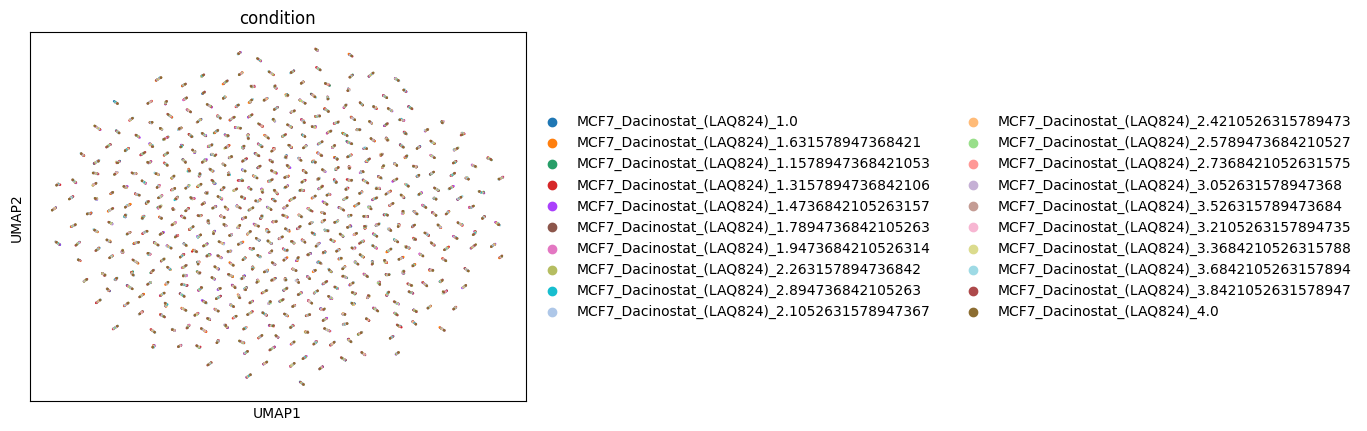

In [235]:
sc.pl.umap(adata_ood_result, color="condition")

In [220]:
adata_ood_result.obs["dose"] = adata_ood_result.obs.apply(get_dose_from_condition, axis=1)

In [221]:
adata_ood_result = adata_ood[(adata_ood.obs["cell_line"]=="MCF7") & (adata_ood.obs["drug"]=="Dacinostat_(LAQ824)")]

In [222]:
adata_ood_result.obs["condition"].value_counts()

condition
MCF7_Dacinostat_(LAQ824)_10.0       454
MCF7_Dacinostat_(LAQ824)_10000.0    435
MCF7_Dacinostat_(LAQ824)_1000.0     358
MCF7_Dacinostat_(LAQ824)_100.0      320
Name: count, dtype: int64

In [223]:
adata_all = ad.concat((adata_ood_result, adata_ood_result), join="outer")

In [224]:
adata_all.obs

cell_type     dose dose_character  \
A01_E09_RT_BC_129_Lig_BC_265-1-0      MCF7     10.0             10   
A01_E09_RT_BC_152_Lig_BC_328-1-0      MCF7  10000.0          10000   
A01_E09_RT_BC_202_Lig_BC_303-1-0      MCF7    100.0            100   
A01_E09_RT_BC_219_Lig_BC_335-1-0      MCF7   1000.0           1000   
A01_E09_RT_BC_274_Lig_BC_119-1-0      MCF7     10.0             10   
...                                    ...      ...            ...   
9995                                   NaN      4.0            NaN   
9996                                   NaN      4.0            NaN   
9997                                   NaN      4.0            NaN   
9998                                   NaN      4.0            NaN   
9999                                   NaN      4.0            NaN   

                                 dose_pattern g1s_score g2m_score  \
A01_E09_RT_BC_129_Lig_BC_265-1-0            4  2.092470  0.884173   
A01_E09_RT_BC_152_Lig_BC_328-1-0            1  2.853289  1.964209   
A01_E09_RT_BC_202_Lig_BC_303-1-0            3  1.487790  1.487790   
A01_E09_RT_BC_219_Lig_BC_335-1-0            2  1.663198  2.003402   
A01_E09_RT_BC_274_Lig_BC_119-1-0            4  0.963303  0.963303   
...                                       ...       ...       ...   
9995                                      NaN       NaN       NaN   
9996                                      NaN       NaN       NaN   
9997                                      NaN       NaN       NaN   
9998                                      NaN       NaN       NaN   
9999                                      NaN       NaN       NaN   

                                      pathway        pathway_level_1  \
A01_E09_RT_BC_129_Lig_BC_265-1-0  Epigenetics  Epigenetic regulation   
A01_E09_RT_BC_152_Lig_BC_328-1-0  Epigenetics  Epigenetic regulation   
A01_E09_RT_BC_202_Lig_BC_303-1-0  Epigenetics  Epigenetic regulation   
A01_E09_RT_BC_219_Lig_BC_335-1-0  Epigenetics  Epigenetic regulation   
A01_E09_RT_BC_274_Lig_BC_119-1-0  Epigenetics  Epigenetic regulation   
...                                       ...                    ...   
9995                                      NaN                    NaN   
9996                                      NaN                    NaN   
9997                                      NaN                    NaN   
9998                                      NaN                    NaN   
9999                                      NaN                    NaN   

                                        pathway_level_2  \
A01_E09_RT_BC_129_Lig_BC_265-1-0  Histone deacetylation   
A01_E09_RT_BC_152_Lig_BC_328-1-0  Histone deacetylation   
A01_E09_RT_BC_202_Lig_BC_303-1-0  Histone deacetylation   
A01_E09_RT_BC_219_Lig_BC_335-1-0  Histone deacetylation   
A01_E09_RT_BC_274_Lig_BC_119-1-0  Histone deacetylation   
...                                                 ...   
9995                                                NaN   
9996                                                NaN   
9997                                                NaN   
9998                                                NaN   
9999                                                NaN   

                                               product_dose  ... pubchem_name  \
A01_E09_RT_BC_129_Lig_BC_265-1-0     Dacinostat (LAQ824)_10  ...          NaN   
A01_E09_RT_BC_152_Lig_BC_328-1-0  Dacinostat (LAQ824)_10000  ...          NaN   
A01_E09_RT_BC_202_Lig_BC_303-1-0    Dacinostat (LAQ824)_100  ...          NaN   
A01_E09_RT_BC_219_Lig_BC_335-1-0   Dacinostat (LAQ824)_1000  ...          NaN   
A01_E09_RT_BC_274_Lig_BC_119-1-0     Dacinostat (LAQ824)_10  ...          NaN   
...                                                     ...  ...          ...   
9995                                                    NaN  ...          NaN   
9996                                                    NaN  ...          NaN   
9997                                                    NaN 

In [225]:
sc.pp.pca(adata_all)

In [226]:
sc.pp.neighbors(adata_all)
sc.tl.umap(adata_all)

In [229]:
adata_ood.obs["logdose"]

index
A01_E09_RT_BC_108_Lig_BC_256-0-0    1.0
A01_E09_RT_BC_116_Lig_BC_193-0-0    1.0
A01_E09_RT_BC_129_Lig_BC_15-0-0     4.0
A01_E09_RT_BC_136_Lig_BC_372-0-0    3.0
A01_E09_RT_BC_136_Lig_BC_6-0-0      3.0
                                   ... 
H12_E09_RT_BC_353_Lig_BC_331-1      0.0
H12_E09_RT_BC_85_Lig_BC_284-1       0.0
H12_F10_RT_BC_151_Lig_BC_60-1       0.0
H12_F10_RT_BC_383_Lig_BC_377-1      0.0
H12_F10_RT_BC_75_Lig_BC_115-1       0.0
Name: logdose, Length: 20173, dtype: category
Categories (5, float64): [0.0, 1.0, 2.0, 3.0, 4.0]

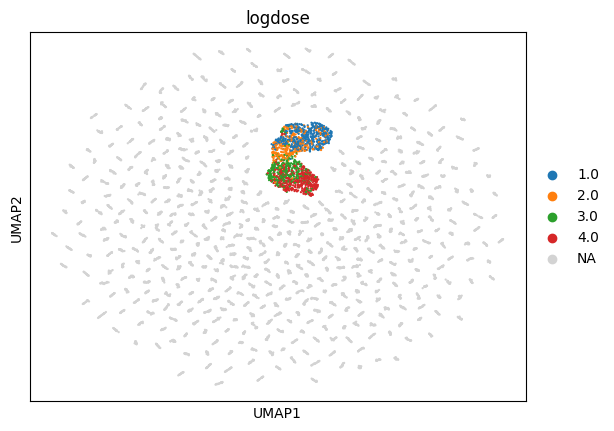

In [232]:
sc.pl.umap(adata_all, color="logdose")

In [186]:
res = pd.read_csv("/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/results/allocation/ood_metrics_decoded.csv")

In [199]:
res[(res.model=="otfm") & (res["split"]==5) & (res["variable"].str.contains("10000"))].sort_values("value")

Unnamed: 0 model     metric  \
11002         377  otfm  r_squared   
10912         287  otfm  r_squared   
10842         217  otfm  r_squared   
10702          77  otfm  r_squared   
10982         357  otfm  r_squared   
11037         412  otfm  r_squared   
10682          57  otfm  r_squared   
10962         337  otfm  r_squared   
10932         307  otfm  r_squared   

                                           variable     value  split  
11002  MCF7_Quisinostat_(JNJ-26481585)_2HCl_10000.0  0.675042      5  
10912              MCF7_Belinostat_(PXD101)_10000.0  0.696236      5  
10842                       K562_Hesperadin_10000.0  0.763719      5  
10702             A549_Givinostat_(ITF2357)_10000.0  0.772818      5  
10982                       MCF7_Hesperadin_10000.0  0.860060      5  
11037            MCF7_Tanespimycin_(17-AAG)_10000.0  0.879834      5  
10682                 A549_Flavopiridol_HCl_10000.0  0.945265      5  
10962             MCF7_Givinostat_(ITF2357)_10000.0  0.953000      5  
10932              MCF7_Dacinostat_(LAQ824)_10000.0  0.960307      5

In [195]:
res[(res.model=="otfm")]

Unnamed: 0 model     metric                            variable  \
2               2  otfm  r_squared                   A549_(+)-JQ1_10.0   
7               7  otfm  r_squared                  A549_(+)-JQ1_100.0   
12             12  otfm  r_squared                 A549_(+)-JQ1_1000.0   
17             17  otfm  r_squared                A549_(+)-JQ1_10000.0   
22             22  otfm  r_squared        A549_AC480_(BMS-599626)_10.0   
...           ...   ...        ...                                 ...   
11017         392  otfm  r_squared                 MCF7_TAK-901_1000.0   
11022         397  otfm  r_squared     MCF7_Tanespimycin_(17-AAG)_10.0   
11027         402  otfm  r_squared    MCF7_Tanespimycin_(17-AAG)_100.0   
11032         407  otfm  r_squared   MCF7_Tanespimycin_(17-AAG)_1000.0   
11037         412  otfm  r_squared  MCF7_Tanespimycin_(17-AAG)_10000.0   

          value  split  
2      0.986635      1  
7      0.957462      1  
12     0.865279      1  
17     0.843068      1  
22     0.989673      1  
...         ...    ...  
11017  0.921915      5  
11022  0.972406      5  
11027  0.908560      5  
11032  0.891221      5  
11037  0.879834      5  

[2208 rows x 6 columns]

In [188]:
adata_all.obs["condition"].value_counts()

condition
MCF7_Quisinostat_(JNJ-26481585)_2HCl_1.0                   500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_2.5789473684210527    500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_4.0                   500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_3.8421052631578947    500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_3.6842105263157894    500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_3.3684210526315788    500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_3.2105263157894735    500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_3.526315789473684     500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_3.052631578947368     500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_1.631578947368421     500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_2.7368421052631575    500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_2.4210526315789473    500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_2.1052631578947367    500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_2.894736842105263     500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_2.263157894736842     500
MCF7_Quisinostat_(JNJ-26481585)_2HCl_1.947368

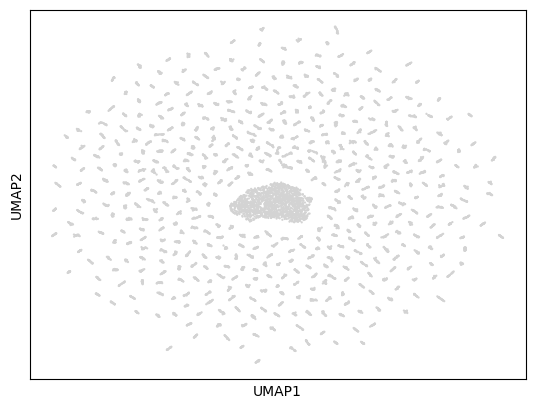

In [185]:
sc.pl.umap(adata_all)

In [ ]:
covariate_data_ood = covariate_data_ood[(covariate_data_ood["cell_line"]=="MCF7") & (covariate_data_ood["drug"]=="Quisinostat_(JNJ-26481585)_2HCl")]

In [66]:
adata_ood_result.write("/lustre/groups/ml01/workspace/ot_perturbation/analysis/sciplex/pseudodosages_split_5.h5ad")

In [67]:
sc.pp.pca(adata_ood_result)

In [68]:
sc.pp.neighbors(adata_ood_result)
sc.tl.umap(adata_ood_result)

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


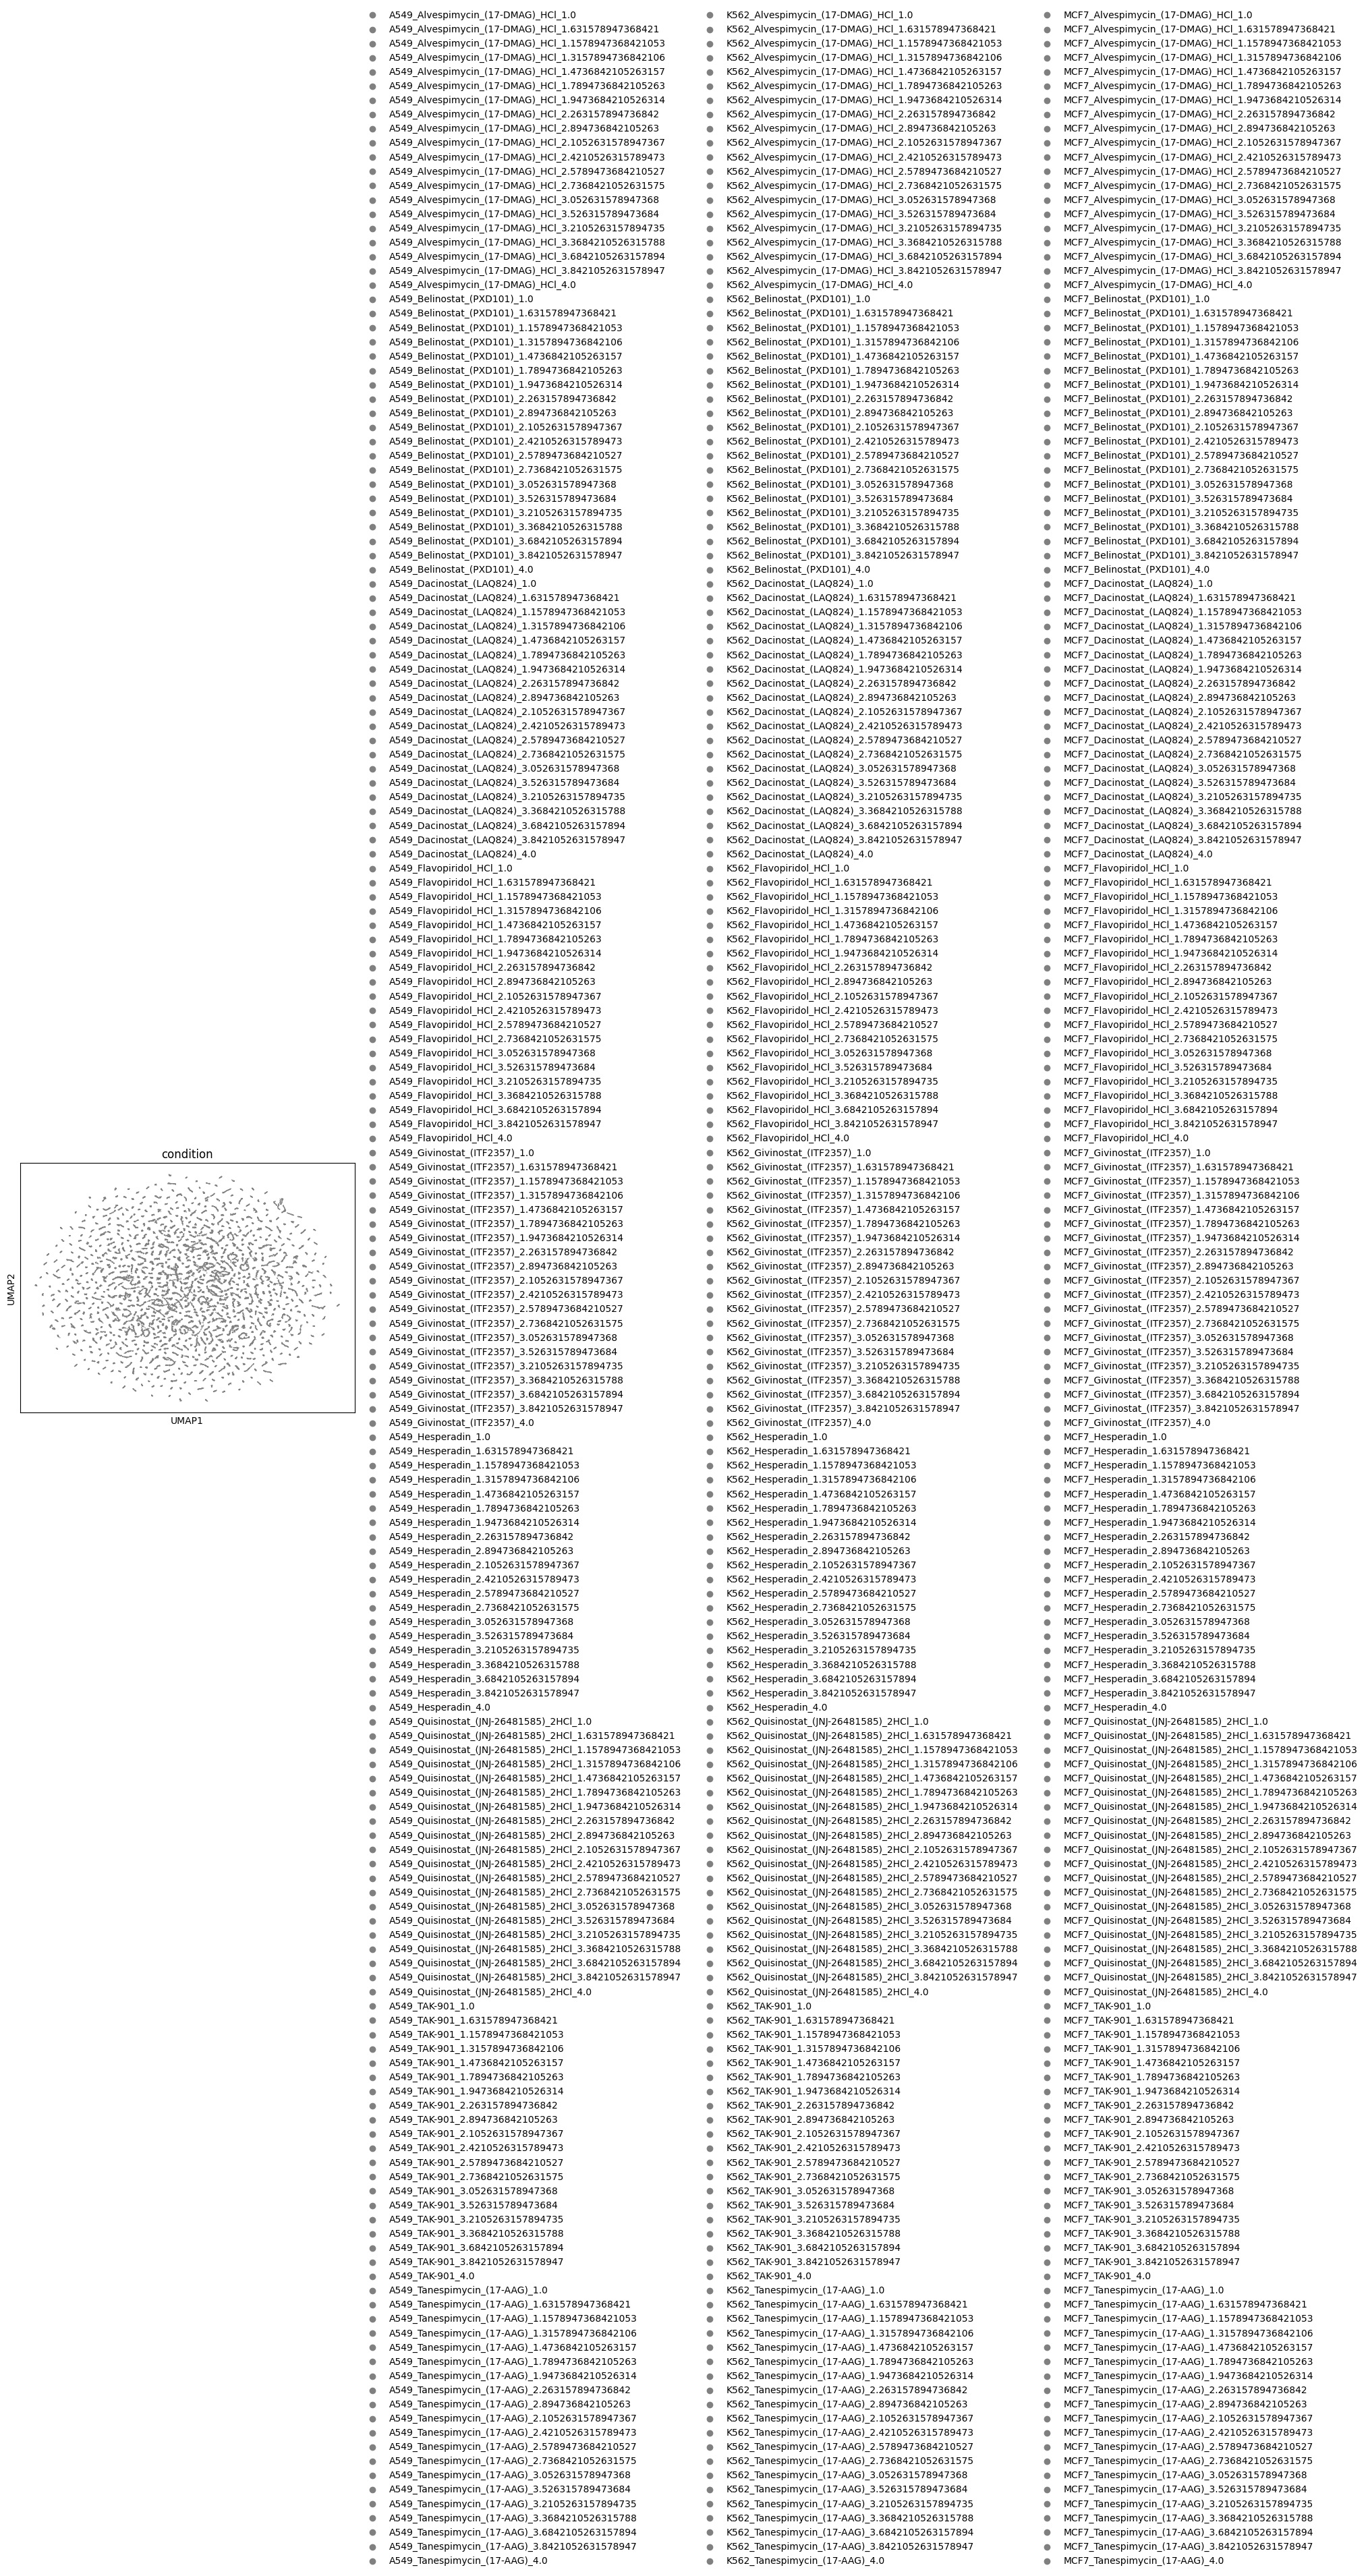

In [69]:
sc.pl.umap(adata_ood_result, color="condition")

In [128]:
conds_to_choose = [el for el in adata_ood_result.obs["condition"].unique() if "MCF7_Givin" in el]

In [129]:
conds_to_choose

['MCF7_Givinostat_(ITF2357)_1.0',
 'MCF7_Givinostat_(ITF2357)_1.1578947368421053',
 'MCF7_Givinostat_(ITF2357)_1.3157894736842106',
 'MCF7_Givinostat_(ITF2357)_1.4736842105263157',
 'MCF7_Givinostat_(ITF2357)_1.631578947368421',
 'MCF7_Givinostat_(ITF2357)_1.7894736842105263',
 'MCF7_Givinostat_(ITF2357)_1.9473684210526314',
 'MCF7_Givinostat_(ITF2357)_2.1052631578947367',
 'MCF7_Givinostat_(ITF2357)_2.263157894736842',
 'MCF7_Givinostat_(ITF2357)_2.4210526315789473',
 'MCF7_Givinostat_(ITF2357)_2.5789473684210527',
 'MCF7_Givinostat_(ITF2357)_2.7368421052631575',
 'MCF7_Givinostat_(ITF2357)_2.894736842105263',
 'MCF7_Givinostat_(ITF2357)_3.052631578947368',
 'MCF7_Givinostat_(ITF2357)_3.2105263157894735',
 'MCF7_Givinostat_(ITF2357)_3.3684210526315788',
 'MCF7_Givinostat_(ITF2357)_3.526315789473684',
 'MCF7_Givinostat_(ITF2357)_3.6842105263157894',
 'MCF7_Givinostat_(ITF2357)_3.8421052631578947',
 'MCF7_Givinostat_(ITF2357)_4.0']

In [130]:
adata_ood_result.obs["condition"].value_counts()

condition
A549_Alvespimycin_(17-DMAG)_HCl_1.0         56
A549_Hesperadin_3.526315789473684           56
A549_Hesperadin_3.3684210526315788          56
A549_Hesperadin_3.6842105263157894          56
A549_Hesperadin_3.8421052631578947          56
                                            ..
MCF7_Flavopiridol_HCl_1.631578947368421     46
MCF7_Flavopiridol_HCl_1.1578947368421053    46
MCF7_Flavopiridol_HCl_1.3157894736842106    46
MCF7_Flavopiridol_HCl_1.4736842105263157    46
MCF7_Tanespimycin_(17-AAG)_4.0              46
Name: count, Length: 540, dtype: int64

In [131]:

bdata = adata_ood_result[adata_ood_result.obs["condition"].isin(conds_to_choose)]

In [132]:
bdata.obs["condition"].value_counts()


condition
MCF7_Givinostat_(ITF2357)_1.0                   46
MCF7_Givinostat_(ITF2357)_1.631578947368421     46
MCF7_Givinostat_(ITF2357)_3.8421052631578947    46
MCF7_Givinostat_(ITF2357)_3.6842105263157894    46
MCF7_Givinostat_(ITF2357)_3.3684210526315788    46
MCF7_Givinostat_(ITF2357)_3.2105263157894735    46
MCF7_Givinostat_(ITF2357)_3.526315789473684     46
MCF7_Givinostat_(ITF2357)_3.052631578947368     46
MCF7_Givinostat_(ITF2357)_2.7368421052631575    46
MCF7_Givinostat_(ITF2357)_2.5789473684210527    46
MCF7_Givinostat_(ITF2357)_2.4210526315789473    46
MCF7_Givinostat_(ITF2357)_2.1052631578947367    46
MCF7_Givinostat_(ITF2357)_2.894736842105263     46
MCF7_Givinostat_(ITF2357)_2.263157894736842     46
MCF7_Givinostat_(ITF2357)_1.9473684210526314    46
MCF7_Givinostat_(ITF2357)_1.7894736842105263    46
MCF7_Givinostat_(ITF2357)_1.4736842105263157    46
MCF7_Givinostat_(ITF2357)_1.3157894736842106    46
MCF7_Givinostat_(ITF2357)_1.1578947368421053    46
MCF7_Givinostat_(ITF2

In [133]:
unique_condition_indices = bdata.obs.groupby("condition").apply(lambda x: x.index[0])

# Subset the AnnData object to keep only those cells
bdata_unique = bdata[unique_condition_indices]

/tmp/ipykernel_3383580/3235617008.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unique_condition_indices = bdata.obs.groupby("condition").apply(lambda x: x.index[0])
/tmp/ipykernel_3383580/3235617008.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_condition_indices = bdata.obs.groupby("condition").apply(lambda x: x.index[0])


In [134]:
def get_dose_from_condition(x):
    return float(x["condition"].split("_")[-1])

In [135]:
bdata_unique.obs["dose"] = bdata_unique.obs.apply(get_dose_from_condition, axis=1)

/tmp/ipykernel_3383580/2042054190.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  bdata_unique.obs["dose"] = bdata_unique.obs.apply(get_dose_from_condition, axis=1)


In [136]:
bdata.obs["dose"] = bdata.obs.apply(get_dose_from_condition, axis=1)

/tmp/ipykernel_3383580/1807853792.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  bdata.obs["dose"] = bdata.obs.apply(get_dose_from_condition, axis=1)


In [137]:
sc.pp.pca(bdata_unique)

In [138]:
sc.pp.neighbors(bdata_unique)

In [139]:
sc.tl.umap(bdata_unique)

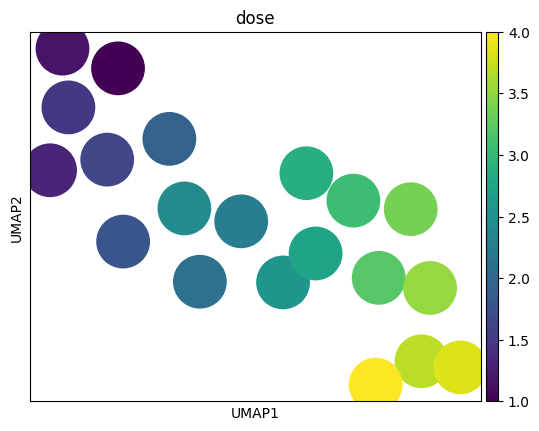

In [140]:

sc.pl.umap(bdata_unique, color="dose")

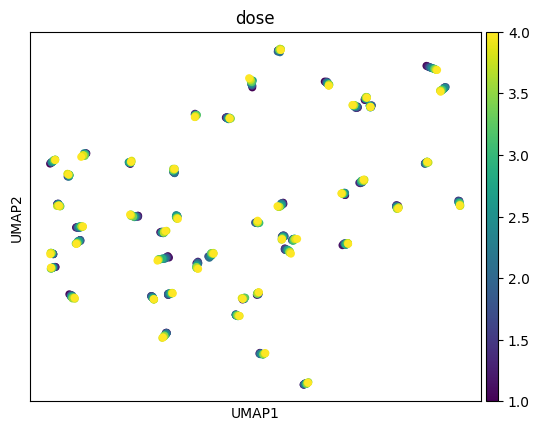

In [141]:
sc.pl.umap(bdata,  color="dose")

In [142]:
bdata.obs["condition"].value_counts()

condition
MCF7_Givinostat_(ITF2357)_1.0                   46
MCF7_Givinostat_(ITF2357)_1.631578947368421     46
MCF7_Givinostat_(ITF2357)_3.8421052631578947    46
MCF7_Givinostat_(ITF2357)_3.6842105263157894    46
MCF7_Givinostat_(ITF2357)_3.3684210526315788    46
MCF7_Givinostat_(ITF2357)_3.2105263157894735    46
MCF7_Givinostat_(ITF2357)_3.526315789473684     46
MCF7_Givinostat_(ITF2357)_3.052631578947368     46
MCF7_Givinostat_(ITF2357)_2.7368421052631575    46
MCF7_Givinostat_(ITF2357)_2.5789473684210527    46
MCF7_Givinostat_(ITF2357)_2.4210526315789473    46
MCF7_Givinostat_(ITF2357)_2.1052631578947367    46
MCF7_Givinostat_(ITF2357)_2.894736842105263     46
MCF7_Givinostat_(ITF2357)_2.263157894736842     46
MCF7_Givinostat_(ITF2357)_1.9473684210526314    46
MCF7_Givinostat_(ITF2357)_1.7894736842105263    46
MCF7_Givinostat_(ITF2357)_1.4736842105263157    46
MCF7_Givinostat_(ITF2357)_1.3157894736842106    46
MCF7_Givinostat_(ITF2357)_1.1578947368421053    46
MCF7_Givinostat_(ITF2

In [143]:
fdata = bdata[bdata.obs["dose"].isin([1.000000, 1.631578947368421, 2.894736842105263, 4.000000])]

In [144]:
fdata.obs["dose"].value_counts()

dose
1.000000    46
1.631579    46
2.894737    46
4.000000    46
Name: count, dtype: int64

In [145]:
sc.pp.neighbors(fdata)
sc.tl.umap(fdata)


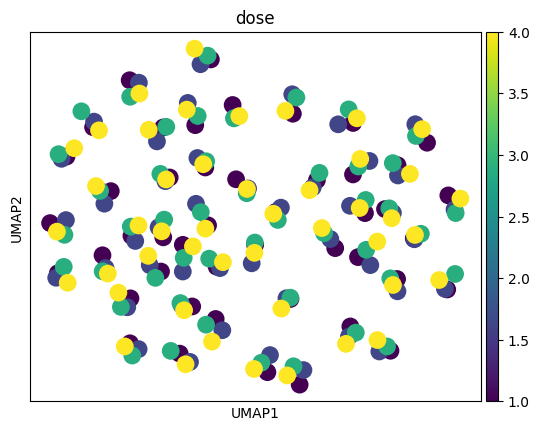

In [146]:
sc.pl.umap(fdata, color="dose")